# Mobile Net
In dit bestand ga ik kijken naar hoe ik MobileNet van Google kan gaan gebruiken om uit onze dataset containers te gaan labelen. Ik wil de foto's met behulp van Mobile Net eerst gaan labelen op wel of geen container zichtbaar, omdat wij een set van 90.000 foto's geleverd hebben gekregen waarvan niks gelabeld is. 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Data Prep

In [ ]:
base_dir = "../Images"

print("Submappen:", os.listdir(base_dir))


Submappen: ['Geen containers', 'Containers']


In [ ]:
img_height = 224
img_width = 224
batch_size = 32
seed = 42

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # MobileNetV2 preprocessing
    validation_split=0.2,                      # 80% train, 20% val
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',       # Containers vs Geen containers --> Binaire output
    subset='training',
    seed=seed
)

val_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=seed
)

print("Class indices:", train_generator.class_indices)


Found 3492 images belonging to 2 classes.
Found 872 images belonging to 2 classes.
Class indices: {'Containers': 0, 'Geen containers': 1}
Found 872 images belonging to 2 classes.
Class indices: {'Containers': 0, 'Geen containers': 1}


# Modeling

In [ ]:
# MobileNetV2 basis laden (zonder top)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False  # alleen de nieuwe top trainen die ik erop ga zetten

base_model.summary()


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Model opbouwen bovenop MobileNetV2
inputs = layers.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # binary (0-1) wel of geen container

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
epochs = 10  # kan je later verhogen voor langere trainings sessie

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


/Users/gerrit/miniconda3/envs/AI_2526_py311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.5284 - loss: 0.7829 - val_accuracy: 0.5183 - val_loss: 0.7291
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.5284 - loss: 0.7829 - val_accuracy: 0.5183 - val_loss: 0.7291
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.5982 - loss: 0.7009 - val_accuracy: 0.5814 - val_loss: 0.6884
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.5982 - loss: 0.7009 - val_accuracy: 0.5814 - val_loss: 0.6884
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.6581 - loss: 0.6302 - val_accuracy: 0.6021 - val_loss: 0.6705
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.6581 - loss: 0.6302 - val_accuracy: 0.6021 - val_loss: 0.6705
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.6859 - loss: 0.5973 - val_accuracy: 0.6250 - val_loss: 0.6474
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.6859 - loss: 0

# Evaluation

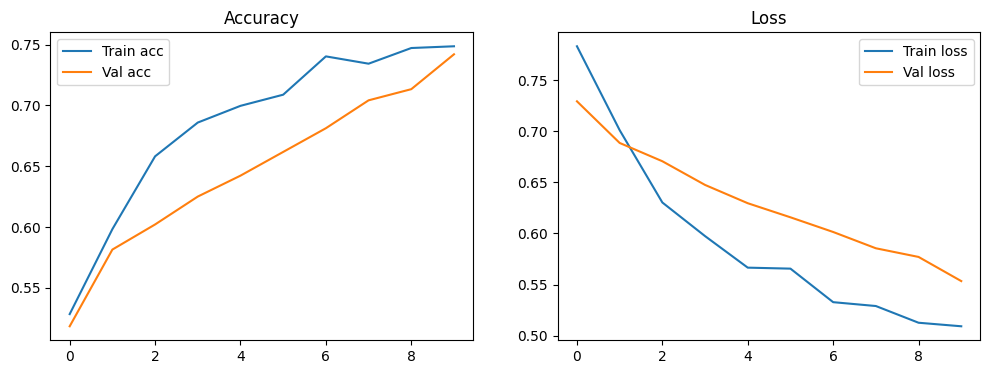

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train acc')
plt.plot(epochs_range, val_acc, label='Val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train loss')
plt.plot(epochs_range, val_loss, label='Val loss')
plt.legend()
plt.title('Loss')

plt.show()


In [22]:
extra_train_history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.7592 - loss: 0.4945 - val_accuracy: 0.7374 - val_loss: 0.5531
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.7592 - loss: 0.4945 - val_accuracy: 0.7374 - val_loss: 0.5531
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.7646 - loss: 0.4913 - val_accuracy: 0.7649 - val_loss: 0.5242
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.7646 - loss: 0.4913 - val_accuracy: 0.7649 - val_loss: 0.5242
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - accuracy: 0.7635 - loss: 0.4875 - val_accuracy: 0.7718 - val_loss: 0.5192
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - accuracy: 0.7635 - loss: 0.4875 - val_accuracy: 0.7718 - val_loss: 0.5192
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.7781 - loss: 0.4850 - val_accuracy: 0.7787 - val_loss: 0.5055
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.7781 - loss: 0

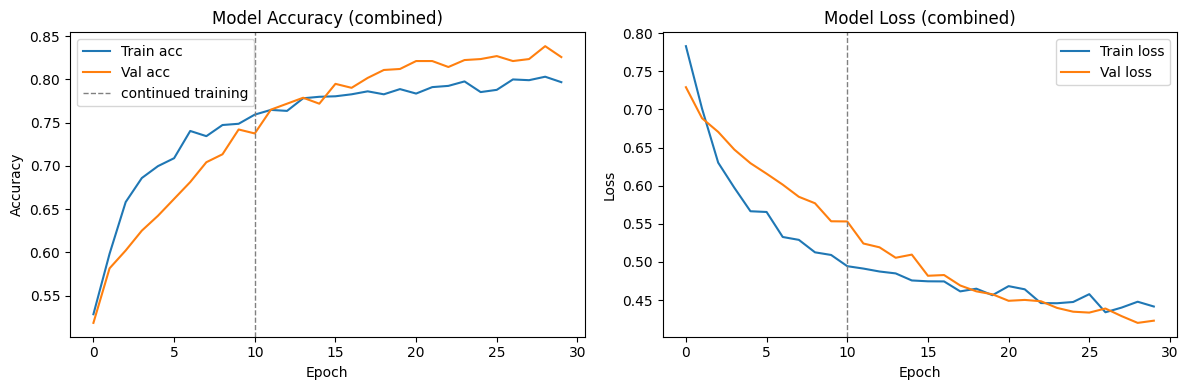

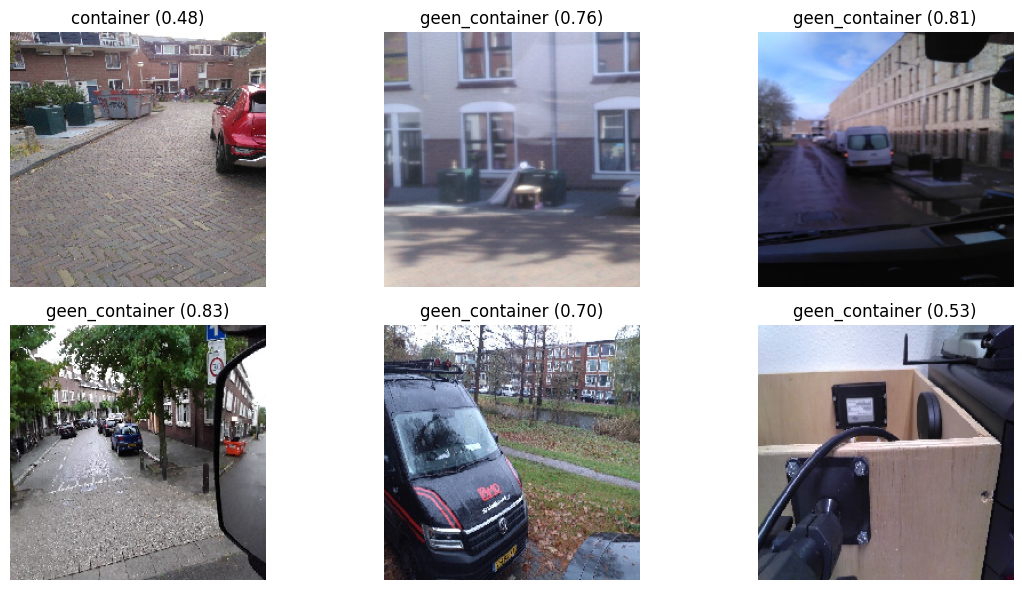

In [ ]:
acc_full = acc + extra_train_history.history['accuracy']
val_acc_full = val_acc + extra_train_history.history['val_accuracy']
loss_full = loss + extra_train_history.history['loss']
val_loss_full = val_loss + extra_train_history.history['val_loss']

epochs_full = range(len(acc_full))

# plot training/validation accuracy & loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_full, acc_full, label='Train acc')
plt.plot(epochs_full, val_acc_full, label='Val acc')
plt.axvline(len(acc), color='gray', linestyle='--', linewidth=1, label='continued training')
plt.title('Model Accuracy (combined)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_full, loss_full, label='Train loss')
plt.plot(epochs_full, val_loss_full, label='Val loss')
plt.axvline(len(loss), color='gray', linestyle='--', linewidth=1)
plt.title('Model Loss (combined)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

samples = np.concatenate([samples_with[:3], samples_without[:3]])
plt.figure(figsize=(12, 6))
for i, p in enumerate(samples):
    img_loaded = tf.keras.utils.load_img(p, target_size=(img_height, img_width))
    arr = tf.keras.utils.img_to_array(img_loaded)
    arr_proc = preprocess_input(arr)
    pred = model.predict(np.expand_dims(arr_proc, 0), verbose=0)[0, 0]
    # based on existing class_names = ['container', 'geen_container']
    pred_label = class_names[1] if pred >= 0.5 else class_names[0]
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_loaded)
    plt.title(f"{pred_label} ({pred:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix

# Eval: precision & recall (use a non-shuffling generator to keep labels aligned)

val_eval_gen = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=seed
)

y_true = val_eval_gen.classes
y_pred_prob = model.predict(val_eval_gen, verbose=1)
y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)

print("Precision (pos=1):", precision_score(y_true, y_pred))
print("Recall    (pos=1):", recall_score(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

Found 872 images belonging to 2 classes.


/Users/gerrit/miniconda3/envs/AI_2526_py311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step
Precision (pos=1): 0.8543689320388349
Recall    (pos=1): 0.851063829787234

Classification report:
                precision    recall  f1-score   support

     container       0.78      0.79      0.79       355
geen_container       0.85      0.85      0.85       517

      accuracy                           0.83       872
     macro avg       0.82      0.82      0.82       872
  weighted avg       0.83      0.83      0.83       872

Confusion matrix:
 [[280  75]
 [ 77 440]]
Precision (pos=1): 0.8543689320388349
Recall    (pos=1): 0.851063829787234

Classification report:
                precision    recall  f1-score   support

     container       0.78      0.79      0.79       355
geen_container       0.85      0.85      0.85       517

      accuracy                           0.83       872
     macro avg       0.82      0.82      0.82       872
  weighted avg       0.83      0.83      0.83       872



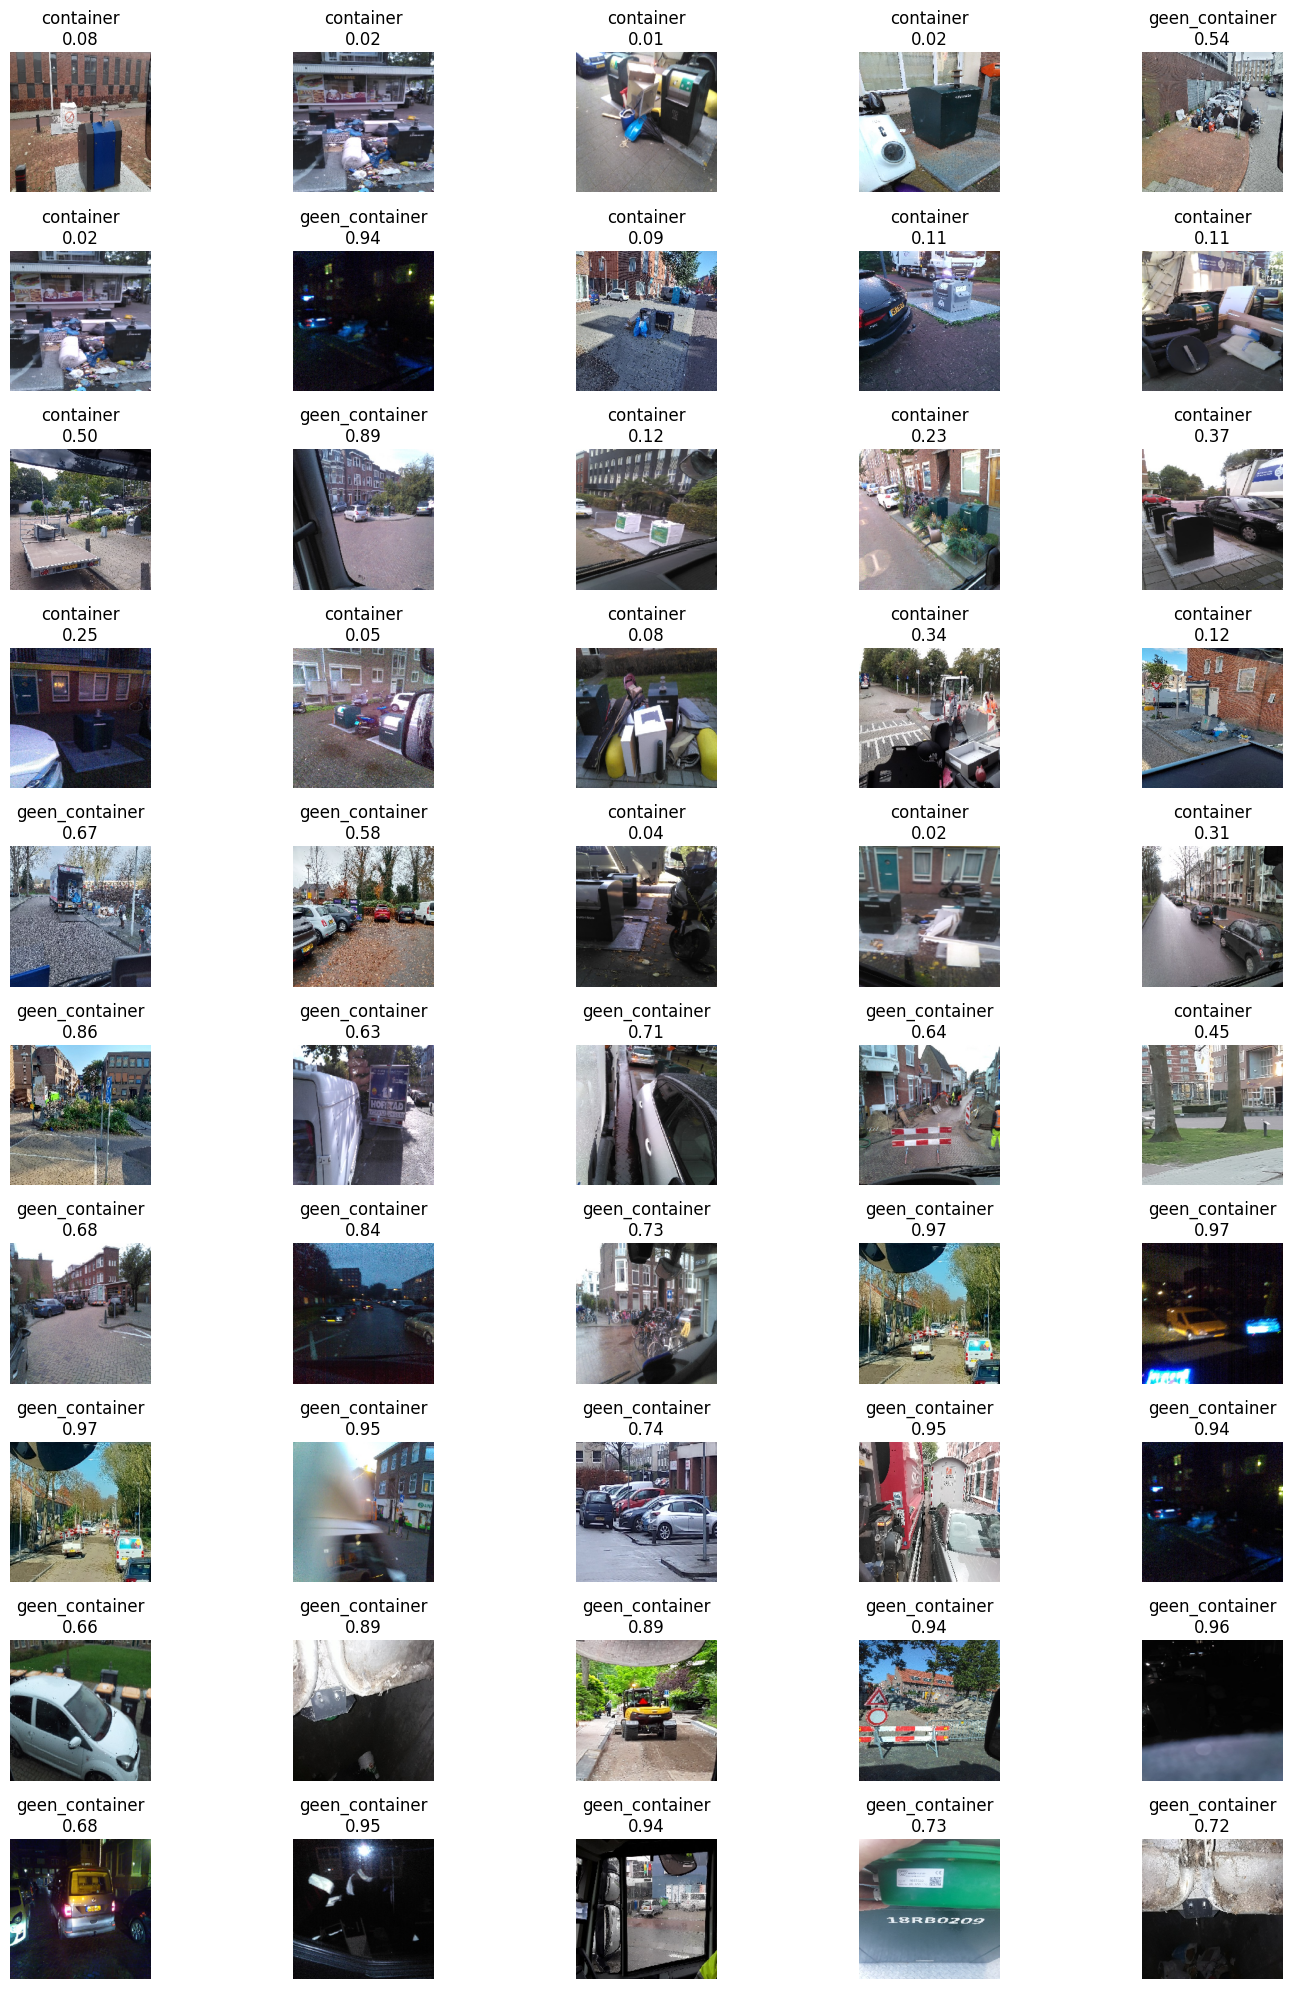

In [30]:
import random

random.seed(seed)
test_with = random.sample(container_images, 25)
test_without = random.sample(no_container_images, 25)
test_images = test_with + test_without

plt.figure(figsize=(15, 20))
for idx, img_path in enumerate(test_images):
    img_loaded = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    arr = tf.keras.utils.img_to_array(img_loaded)
    arr_proc = preprocess_input(arr)
    prob = float(model.predict(np.expand_dims(arr_proc, 0), verbose=0)[0, 0])
    pred_label = class_names[1] if prob >= 0.5 else class_names[0]
    plt.subplot(10, 5, idx + 1)
    plt.imshow(img_loaded)
    plt.title(f"{pred_label}\n{prob:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Model opslaan na training
model.save(os.path.join('Models', 'mobilenet_container_model.keras'))


In [42]:
# Een functie voor het opslaan van het model
def save_model(model, model_name):
    model.save(os.path.join('Models', model_name))

# Voorbeeld Hergebruiken Van Opgeslagen Modellen

In [37]:
# Voorbeeld: model opnieuw laden en verder trainen of gebruiken
from tensorflow.keras.models import load_model
loaded_model = load_model('Models/mobilenet_container_model.keras')
loaded_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

# Verder Onderzoeken naar aanpassingen om het model te verbeteren

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 313ms/step - accuracy: 0.7099 - loss: 0.5790 - val_accuracy: 0.7500 - val_loss: 0.5904
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 313ms/step - accuracy: 0.7099 - loss: 0.5790 - val_accuracy: 0.7500 - val_loss: 0.5904
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 261ms/step - accuracy: 0.7383 - loss: 0.5261 - val_accuracy: 0.7695 - val_loss: 0.5792
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 261ms/step - accuracy: 0.7383 - loss: 0.5261 - val_accuracy: 0.7695 - val_loss: 0.5792
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 261ms/step - accuracy: 0.7595 - loss: 0.4992 - val_accuracy: 0.8016 - val_loss: 0.5156
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 261ms/step - accuracy: 0.7595 - loss: 0.4992 - val_accuracy: 0.8016 - val_loss: 0.5156
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 265ms/step - accuracy: 0.7629 - loss: 0.4926 - val_accuracy: 0.7901 - val_loss: 0.4964
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 265ms/step - accuracy: 0.7629 - loss: 0

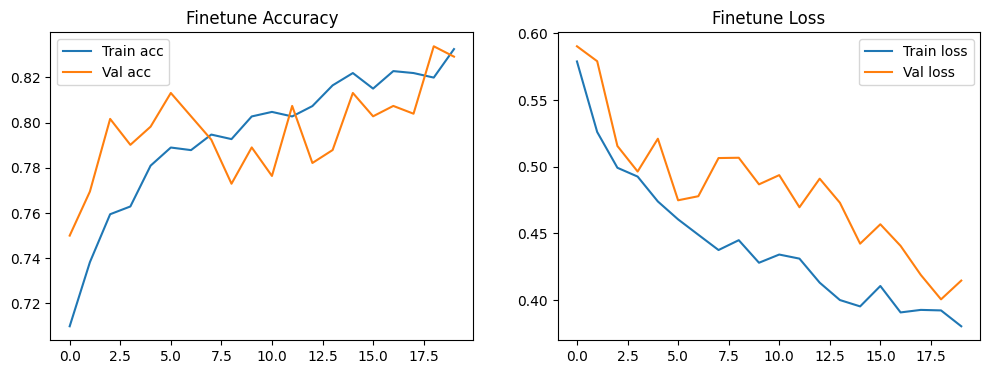

In [51]:
# --- Verder trainen vanaf het beste model ---
from tensorflow.keras.models import load_model
best_model = load_model('../MobileNet/Models/mobilenet_container_model.keras')
best_model.summary()

# Compile opnieuw (optioneel, als je optimizer/learning rate wilt aanpassen)
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # lagere learning rate voor finetuning
    loss='binary_crossentropy',
    metrics=['accuracy']
 )

# Finetuning: eventueel base_model deels unlocken
for layer in best_model.layers[1].layers[-20:]:  # laatste 20 lagen van base_model trainable maken
    layer.trainable = True

# Verder trainen op bestaande data
finetune_epochs = 20
finetune_history = best_model.fit(
    train_generator,
    epochs=finetune_epochs,
    validation_data=val_generator
 )

# Plot nieuwe accuracy/loss
ft_acc = finetune_history.history['accuracy']
ft_val_acc = finetune_history.history['val_accuracy']
ft_loss = finetune_history.history['loss']
ft_val_loss = finetune_history.history['val_loss']

epochs_range = range(len(ft_acc))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, ft_acc, label='Train acc')
plt.plot(epochs_range, ft_val_acc, label='Val acc')
plt.legend()
plt.title('Finetune Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, ft_loss, label='Train loss')
plt.plot(epochs_range, ft_val_loss, label='Val loss')
plt.legend()
plt.title('Finetune Loss')
plt.show()